# Smart-G demo notebook

This is an interactive document allowing to run Smart-G with python and visualize the results. <br>
*Tips*: cells can be executed with shift-enter. Tooltips can be obtained with shift-tab. More information [here](http://ipython.org/notebook.html) or in the help menu. [A table of content can also be added](https://github.com/minrk/ipython_extensions#table-of-contents).

In [1]:
%matplotlib inline
# next 2 lines allow to automatically reload modules that have been changed externally
%reload_ext autoreload
%autoreload 2
import os, sys

try:
    import subprocess
    check = subprocess.check_call(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    ROOTPATH = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8') # Root Git Path
except subprocess.CalledProcessError:
    ROOTPATH = os.getcwd()
sys.path.insert(0, ROOTPATH)

from smartg.smartg import Smartg, Sensor, Get_Sensor
from smartg.smartg import RoughSurface, LambSurface, FlatSurface, Environment, Albedo_cst, RTLSSurface
from smartg.atmosphere import AtmAFGL, Cloud, diff1, read_phase, AerOPAC, od2k
from smartg.water import IOP_1, IOP, IOP_profile
from smartg.albedo import Albedo_speclib, Albedo_cst, Albedo_spectrum, Albedo_map
from smartg.reptran import REPTRAN, reduce_reptran
from smartg.tools.tools import SpherIrr, Irr, reduce_Irr
from luts.luts import LUT, MLUT, Idx, merge, read_mlut
from smartg.tools.smartg_view import compare, plot_polar, spectrum , mdesc 
from smartg.tools.smartg_view import spectrum_view,transect_view,profile_view,phase_view,smartg_view,input_view
import warnings
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Quick Start

## Run your first simulation

In [2]:
m = Smartg().run(wl=500., THVDEG=30.,  NBPHOTONS=1e9, atm=AtmAFGL('afglt'))

Box(children=(FloatProgress(value=0.0, max=1000000000.0), Label(value='')), layout=Layout(align_items='center'…

## How to view the results

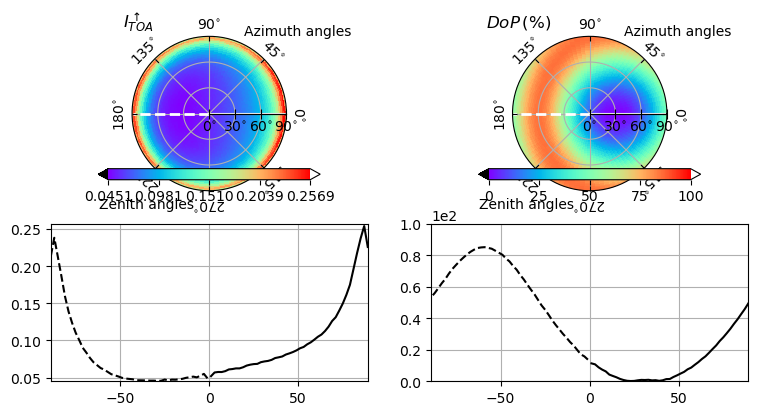

In [3]:
# basic visualization
fig = smartg_view(m)

In [ ]:
# access a LUT within the MLUT
I = m['I_up (TOA)']  # or by index: m[0]
I.desc = mdesc(I.desc) # I descriptor in math Latex format

In [ ]:
I.print_info()

In [ ]:
# access values in this LUT
print(I[5, ::5])  # by index (can be float indices to interpolate)
print(I[Idx(90.), Idx(45.)])  # or by index finding + interpolation

In [ ]:
# calculate polarized light
# use operations between LUT's, and apply sqrt
Q, U = m['Q_up (TOA)'], m['U_up (TOA)']
LP = (Q*Q + U*U).apply(np.sqrt, mdesc('Lp_up (TOA)'))   # second parameter of apply sets the LUT's desc

In [ ]:
#Different visualizations
LP.plot_semi()
LP.plot()
LP.plot_polar()

In [ ]:
I.plot_semi(index=Idx([45]), vmin=0, vmax=0.3)   # the arguments are optional

In [ ]:
# get a sub-LUT from a LUT (here 2D -> 1D)
I.sub()[Idx(90),:].plot()

## A few examples

In [ ]:
# Basic Rayleigh example, no surface, full view
fig= smartg_view(Smartg(rng='CURAND_PHILOX').run(wl=500., THVDEG=30., NBPHOTONS=1e9, atm=AtmAFGL('afglt')), full=True)

In [ ]:
# only Rayleigh with a custom grid, a custom depolarization ratio and a custom surface pressure
fig= smartg_view(Smartg().run(wl=500., THVDEG=30., DEPO=0., NBPHOTONS=1e8,
        atm=AtmAFGL('afglt', grid=np.linspace(100.,0., num=16), P0=990.)))

In [ ]:
# Rayleigh + aerosols (UV), downward radiance at the ground
aer = AerOPAC('urban', 0.4, 550.)
pro = AtmAFGL('afglms', comp=[aer])
fig= smartg_view(Smartg().run(wl=322., THVDEG=60., atm=pro, NBPHOTONS=1e8, OUTPUT_LAYERS=1), field='down (0+)')

In [ ]:
# atmosphere + surface
wl= 490.
azimuth_transect = 10.
fig= smartg_view(Smartg().run(wl, NBPHOTONS=1e8, THVDEG=45.,
        atm=pro,
        surf=LambSurface(ALB=Albedo_cst(0.1))), ind=Idx([azimuth_transect]), QU=True)

In [ ]:
m.describe()

In [ ]:
# atmosphere + surface + océan
atm   = AtmAFGL('afglms', O3=0., NO2=False)
surf  = RoughSurface(WIND=5., NH2O=1.34)
# Case I water Inherent Optical Properties depending on Chlorophyll concentration only
water = IOP_1(chl=0.5, DEPTH=5.)
# compute outputs at the surface and bottom of ocean also, 
# view results for upwelling and downwelling radiances
wl = 500.
th0= 60.
m=Smartg().run(wl, NBPHOTONS=1e8, THVDEG=th0, OUTPUT_LAYERS=3, BEER=1,
                atm=atm,  surf=surf, water=water)
fields=['up (TOA)','up (0+)','up (0-)','down (0+)','down (0-)','down (B)']
logIs =[True,False,True,True,True,False]
for logI,field in zip(logIs,fields):
        fig= smartg_view(m, field=field, logI=logI)

In [ ]:
# surface + ocean
atm   = None
surf  = RoughSurface(WIND=5., NH2O=1.34)
water = IOP_1(chl=0.5, DEPTH=5.)
# compute outputs at the surface also, view results for downwelling at bottom of ocean
fig= smartg_view(Smartg().run(wl, NBPHOTONS=1e8, THVDEG=th0, OUTPUT_LAYERS=3, BEER=1,
            atm=None,  surf=surf, water=water), 
            field='down (B)', logI=True)

In [ ]:
# ocean only
atm   = None
surf  = None
water = IOP_1(chl=0.5, DEPTH=5.)
# compute outputs at the surface also, view results for downwelling at bottom of ocean
fig= smartg_view(Smartg().run(wl, NBPHOTONS=1e8, THVDEG=th0, OUTPUT_LAYERS=3, BEER=1,
            atm=None,  surf=surf, water=water), 
            field='down (B)', logI=True)

# Advanced use

## Local Estimate

In [ ]:
%%time
# In order to compute accurately radiances in particular directions, set the LE mode
# 'le' keyword is a dictionnary containig directions vectors (in radians or deg) and coded as float32
# by default the result is calculated for each Ntheta x Nphi combination
le = {'th_deg': np.linspace(0, 89., num=8), 'phi_deg': np.linspace(360, 0., num=12)}
# revisit atmosphere + surface + ocean
# the number of photons should be dramatically reduces since
# each photon participates to the computation of all directions
wl = 500.
th0= 60.
m = Smartg().run(wl=wl, NBPHOTONS=1e6, THVDEG=th0, OUTPUT_LAYERS=3, le=le,
            atm   = AtmAFGL('afglms', O3=0., NO2=False), 
            surf  = RoughSurface(WIND=5., NH2O=1.34),
            water=IOP_1(chl=0.5, DEPTH=5.))

fig= smartg_view(m, field='up (0-)', logI=True, Imin=-2.5, Imax=-1.)

In [ ]:
# you can also speficy only couples of zenith and azimuth angles, resulting in only 1-dimensional Ncouple output
# using the keyword 'zip':True in the le dictionary. in that case Nphi=Ntheta=Ncouple. 
# You can also specify angles in degree
N  = 12
le = {'th_deg': np.linspace(0, 89., num=N), 'phi_deg': np.linspace(360., 0., num=N), 'zip':True}
mz = Smartg().run(wl=wl, NBPHOTONS=1e6, THVDEG=th0, OUTPUT_LAYERS=3, le=le,
            atm   = AtmAFGL('afglms', O3=0., NO2=False), 
            surf  = RoughSurface(WIND=5., NH2O=1.34),
            water=IOP_1(chl=0.5, DEPTH=5.))
# the result has an "Azimuth angles" axis, but no LUT exhibits dependency on Azimuth angles
mz.describe()

In [ ]:
# Comparison of outputs
# polar scatter plot, with color proportional to I and size to DoLP
f  = plt.figure()
ax = f.add_subplot(111, projection='polar')
I, Q, U = m['I_up (0-)'], m['Q_up (0-)'], m['U_up (0-)']
P = ((Q*Q + U*U)/(I*I)*100).apply(np.sqrt, mdesc('DoLP_up (0-)'))
r, theta = np.meshgrid(m.axis('Zenith angles'), m.axis('Azimuth angles')/180*np.pi)
ax.scatter(theta.ravel(), r.ravel(), 
               c=np.log10(I.data.ravel()), s=P.data.ravel()*50, cmap='jet', alpha=0.5, vmin=-2.5, vmax=-1.)

I, Q, U = mz['I_up (0-)'], mz['Q_up (0-)'], mz['U_up (0-)']
P = ((Q*Q + U*U)/(I*I)*100).apply(np.sqrt, mdesc('DoLP_up (0-)'))
ax.set_ylim([0,90])
ax.scatter(mz.axis('Azimuth angles')/180*np.pi, mz.axis('Zenith angles'), 
               c=np.log10(I.data), s=P.data*50, cmap='jet', alpha=0.5, vmin=-2.5, vmax=-1., marker='s', edgecolors='k')

## Atmospheric profile
Aerosols and Cloud optical properties are those of OPAC. The files containing these properties have been
generated by www.libradtran.org. <br>
For the moment Only spherical particles are handled

In [ ]:
# monochromatic computation for custom aerosols and cloud
wlref = 550.
# Aerosols and cloud optical properties using OPAC database as processed by the the libradtran (www.libradtran.org)
aer = AerOPAC( 'desert', 0.3, wlref) # set AOT at the reference wavelength wl to 0.3 
                                # and set aerosol type to 'desert'
cld = Cloud('wc', 11., 2, 3., 1., wlref) # set cloud to water cloud with reff=11 mic.  
                                # the cloud is located between 2. and 3 km, with
                                # Optical thickness at the reference wavelength wl set to 1. 
                                                              
pro = AtmAFGL('afglt',    # tropical atmosphere
              comp=[aer, cld], # particles in atmosphere are a mix of aerosols and cloud            
              O3 = 0.,   # scale ozone vertical column to 0 Dobson units (here no absoprtion by ozone)
              NO2= False,# disable absorption by NO2
              H2O= 2.,   # scale water vapour column to 2 g/cm-2, but no H2O absoprtion, just hygroscopic computation for aerosols
              P0 = 980., # set sea level pressure to 980 hPa
              tauR=0.1,   # force Rayleigh optical thickness
              grid =   [100., 75., 50., 25., 15., 10., 5., 3., 2., 1.15], # set vertical grid, surface altitude at 1.15 km
              pfgrid = [100., 25., 15., 10., 5., 3., 2., 1.15] # vertical grid for the computation of particles phase functions
             )

azimuth_transect = 30. 
m = Smartg().run(wl=wlref, THVDEG=60., atm=pro, NBPHOTONS=1e9)
_ = smartg_view(m, ind=Idx([azimuth_transect]), logI=True)

In [ ]:
# View inputs
input_view(m, kind='atm', zmax=50)

In [ ]:
# Full aerosol customization
#1) import aerosols scattering matrix from external text file with 5 columns:
# angle, P11, P12, P33, P43 --> pha=read_phase(ROOTPATH + '/smartg/validation/opt_kokha_aer_standard.dat')
# OR angle, F11 = (P11+P12)/2, F22=(P11-P12)/2, F33=P33, F43=P43 (Smartg Iparper convention)
pha=read_phase(ROOTPATH + '/smartg/validation/opt_kokha_aer_nostandard.dat')
pha=read_phase(ROOTPATH + '/smartg/validation/opt_kokha_aer_standard.dat', standard=True) # standard = True to convert standard conv into smartg Iparper conv

#2) Set single scattering albedo of aerosols to 0.80 for each layer and set the aerosol phase function
aer=AerOPAC('maritime_clean',0.3262, wlref, ssa=0.80, phase=pha)

#3) build profile
atm_custom = AtmAFGL('afglmw', comp=[aer]
                    #4) Could also import aerosol profiles (extinction and ssa) from external files
                    #,prof_aer= (aer_ext_valid,aer_ssa_valid)
                    )

azimuth_transect = 5. 
m = Smartg().run(wl=wlref, THVDEG=60., atm=atm_custom, NBPHOTONS=1e9)
_ = smartg_view(m, ind=Idx([azimuth_transect]))

## Multispectral

### Independant spectral computations

Box(children=(FloatProgress(value=0.0, max=10000000.0), Label(value='')), layout=Layout(align_items='center', …

 GPU time:  0.05139267182350159 s
CPU times: user 572 ms, sys: 273 ms, total: 846 ms
Wall time: 1.32 s


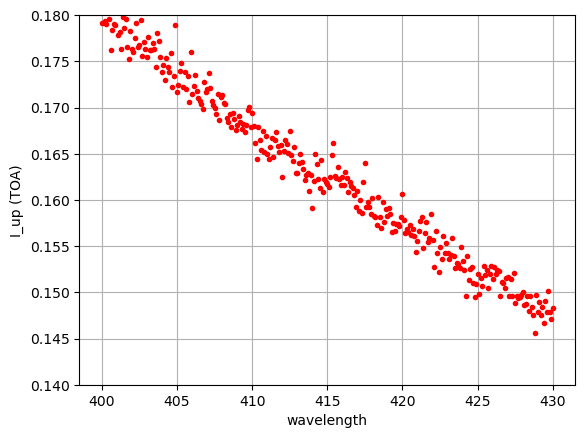

In [2]:
%%time
# multispectral simulation
# computation done independently for each wavelegnth, NBPHOTONS is shared equally
# between all wavelegths (thus Monte Carlo NOISE in the spectrum)
# wavelengths is a list or numpy array
wl = np.linspace(400., 430., num=301)

# monochromatic computation for custom aerosols and cloud
wl0 = 415.
# Aerosols and cloud optical properties using OPAC database as processed by the the libradtran (www.libradtran.org)
aer1 = AerOPAC( 'urban',  0.5, wl0) # set AOT at the reference wavelength wl0 to 0.5 
                                # and set aerosol type to 'urban'
pro = AtmAFGL('afglt',    # tropical atmosphere
              comp   = [aer1], # particles in atmosphere are a mix of aerosols 1 and 2            
              grid   = [100, 75, 50, 30, 20, 10, 5, 2., 1.15], # set vertical grid, surface altitude at 1.15 km
              pfgrid = [100, 10, 5, 2., 1.15],           
              pfwav  = [400., 430.], # wavelengths for which the phase function is computed
                                     # optional, otherwise phase functions are calculated at all bands
                                     # nearest neighbour is then used during the RT computation
              NO2 = True, # NO2 included
              O3  = 0. # no ozone
             )

le={}
surf = RoughSurface()
le.update(th = np.array([0.]) *np.pi/180)
le.update(phi= np.array([0.]) *np.pi/180)
m = Smartg(alt_pp=True, double=True).run(wl=wl, le=le,
           THVDEG=60., NBPHOTONS=1e7,
           atm=pro, OUTPUT_LAYERS=0,
           surf=surf).dropaxis('Zenith angles').dropaxis('Azimuth angles')
m['I_up (TOA)'].plot(fmt='.r', vmin=0.14, vmax=0.18)
print(' GPU time: ', m.attrs['kernel time (s)'], 's')

### Profiles reuse

Box(children=(FloatProgress(value=0.0, max=10000000.0), Label(value='')), layout=Layout(align_items='center', …

 GPU time:  0.051046655893325805 s
CPU times: user 675 ms, sys: 125 ms, total: 800 ms
Wall time: 882 ms


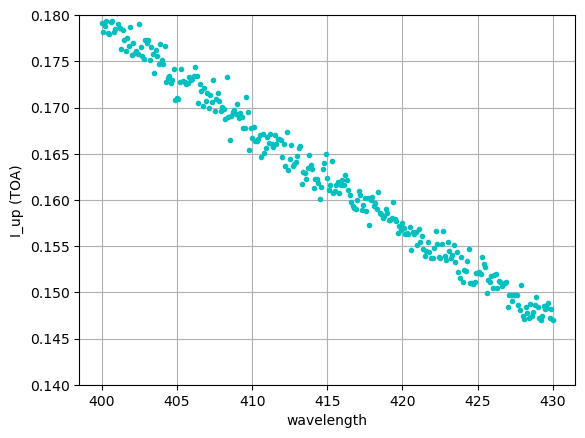

In [3]:
%%time
# once computed, profiles may be re-used
# it could save a lot of time for multi spectral computation 
m2 = Smartg(alt_pp=True, double=True).run(wl=wl, le=le,
           THVDEG=60., NBPHOTONS=1e7,
           atm=m, OUTPUT_LAYERS=0,
           surf=surf).dropaxis('Zenith angles').dropaxis('Azimuth angles')
m2['I_up (TOA)'].plot(fmt='.c', vmin=0.14, vmax=0.18)
print(' GPU time: ', m2.attrs['kernel time (s)'], 's')

### Correlated spectral computations: ALIS method 
The ALIS method is described in <br>
Emde, C., Buras, R., and Mayer, B.: ALIS: An efficient method to
compute high spectral resolution polarized solar radiances using the Monte Carlo approach, J. Quant. Spectrosc. Ra., 112, 1622–1631, 2011.

Box(children=(FloatProgress(value=0.0, max=300000.0), Label(value='')), layout=Layout(align_items='center', di…

 GPU time:  0.22123251152038576 s
CPU times: user 570 ms, sys: 261 ms, total: 830 ms
Wall time: 928 ms


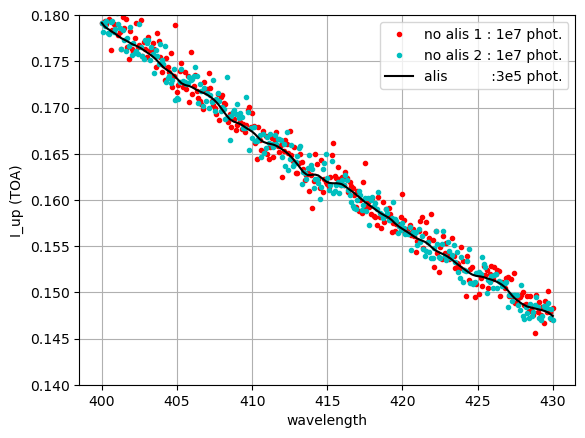

In [4]:
%%time
# Compile with the alis options
Salis = Smartg(alt_pp=True, double=True, alis=True) # with ALIS options, alt_pp is mandatory
# then run specifying the alis_options dictionary
# main keyword is 'nlow' , the number of low spectral resolution computation
NLOW = 31
wl_lr = np.linspace(wl.min(), wl.max(), num=NLOW)
# of the scattering correction terms: specify -1 for all wavelengths
# if the alt_pp option is chosen for compilation: slowest procedure for photon propagation but
# then the cumulative distance traveled by photons in the atmospheric layer is recorded
NB = 3e5
m3 = Salis.run(wl=wl, le=le, alis_options={'nlow':NLOW},
           THVDEG=60., NBPHOTONS=NB, stdev=True,
           atm=m, OUTPUT_LAYERS=0,
           surf=surf).dropaxis('Zenith angles').dropaxis('Azimuth angles')

# for the same number of photons, the spectrum is much less noisy
m ['I_up (TOA)'].plot(fmt='.r', label='no alis 1 : 1e7 phot.', vmin=0.14, vmax=0.18)
m2['I_up (TOA)'].plot(fmt='.c', label='no alis 2 : 1e7 phot.', vmin=0.14, vmax=0.18)
m3['I_up (TOA)'].plot(fmt='-k',  label='alis          :3e5 phot.', vmin=0.14, vmax=0.18)
plt.legend()
print(' GPU time: ', m3.attrs['kernel time (s)'], 's')

In [233]:
# As remarked in Emde et al., 2011, alis method is very efficient for DOAS.
# example : differences in spectra with and without NO2
pro0 = AtmAFGL('afglt', NO2=False, O3=0.,
              comp   = [aer1],       
              grid   = [100, 75, 50, 30, 20, 10, 5, 2., 1.15],
              pfgrid = [100, 10, 5, 2., 1.15],           
              pfwav  = [400., 430.])

m0 = Salis.run(wl=wl, le=le, alis_options={'nlow':31},
           THVDEG=60., NBPHOTONS=3e5, stdev=True,
           atm=pro0, OUTPUT_LAYERS=0,
           surf=surf).dropaxis('Zenith angles').dropaxis('Azimuth angles')
print(' GPU time: ', m0.attrs['kernel time (s)'], 's')

Box(children=(FloatProgress(value=0.0, max=300000.0), Label(value='')), layout=Layout(align_items='center', di…

 GPU time:  0.22026550674438478 s


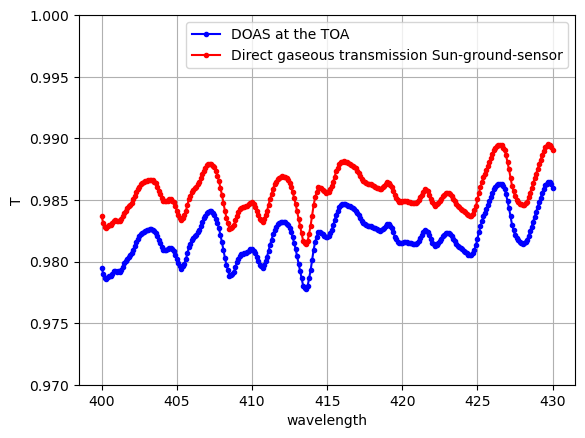

In [234]:
# Differential absorption
DA = (m3['I_up (TOA)']/m0['I_up (TOA)'])
DA.desc = 'DA'
DA.plot(fmt='.b-')
# Overplot NO2 direct transmission
Tdown = (m3['OD_g'].sub()[:,-1]*(-1)/np.cos(np.radians(60.))).apply(np.exp)
Tup   = (m3['OD_g'].sub()[:,-1]*(-1)).apply(np.exp)
T = Tup*Tdown
T.desc = 'T'
T.plot(vmin=0.97, vmax=1, fmt='r.-')
plt.legend(['DOAS at the TOA', 'Direct gaseous transmission Sun-ground-sensor'])

Text(0, 0.5, 'AMF')

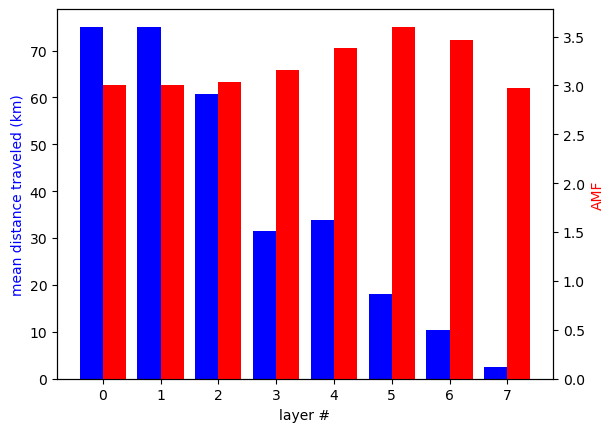

In [235]:
# We can obtain the Air Mass Factors
# 1) Intensity weighted average of Cumulative Distance traveled in each layer
mean_dist = m0['cdist_up (TOA)'][:,1]/m0['cdist_up (TOA)'][:,0]
fig, ax=plt.subplots()
width=0.4
ax.bar(np.arange(mean_dist.shape[0])-width/2, mean_dist, color='b', width=width)
ax.set_ylabel('mean distance traveled (km)', color='b')
ax.set_xlabel('layer #')
# layer thicknesses
thick = abs(np.diff(m0.axis('z_atm')))
# 2) AMF's
ax2 = ax.twinx()
ax2.bar(np.arange(mean_dist.shape[0])+width/2, mean_dist/thick, color='r', width=width)
ax2.set_ylabel('AMF', color='r')

## Water profile
Full profile customization

Box(children=(FloatProgress(value=0.0, max=100000000.0), Label(value='')), layout=Layout(align_items='center',…

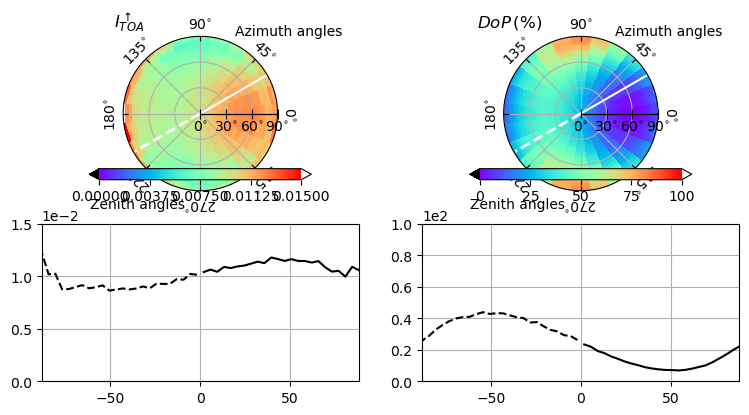

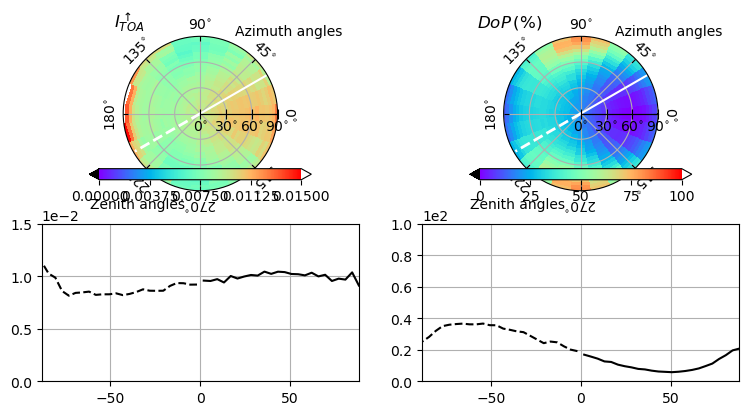

In [31]:
wl  = np.array([450.,550.]) # N=2
grid= [0., -2.5, -5., -7.5, -10.]
# Seafloor albedo, here grey lambertian reflection with albedo of 0.05
ALB=Albedo_cst(0.05)

#1) Read one phase matrix for particles
phaM=read_phase(ROOTPATH + '/smartg/validation/opt_hydrosols.dat', kind='oc', standard=True)
#2) Construct a LUT and fill all levels and all wavelengths with the the read phase matrix, You can of course
# fill this LUT with several phase matrices
pha = LUT(phaM.data[None,None,:,:],
          names = ['wav_phase', 'z_phase'] + phaM.names,
          axes = [np.array([
              wl[0]]), np.array([0.])] + phaM.axes
         )
#3) import vertical profiles of pure water absorption and scattering coefficient, 
# particle absorption and scattering coefficient profiles (in m-1)
# with shape (N wavelengths, M levels)
# !! level Number 0 is not used, the first layer (L=0) is homogeneous with coefficient
# index 1, layer number L-1 is homogeneous with coefficient index M-1

atot = np.array([[0., 0.21841, 0.05465, 0.00924, 0.00924], 
              [0., 0.09881, 0.06415, 0.05650, 0.05650]])
ap   = np.array([[0., 1.25744e-01, 1.34828e-02, 4.79320e-10, 4.79320e-10],
              [0., 3.10215e-02, 3.32626e-03, 1.18250e-10, 1.18250e-10]])
aCDOM= np.array([[0., 8.34474e-02, 3.19477e-02, 2.00125e-05, 2.00125e-05],
              [0., 1.12934e-02, 4.32364e-03, 2.70840e-06, 2.70840e-06]])
aw   = np.array([[0., 0.00922, 0.00922, 0.00922, 0.00922],
              [0., 0.05650, 0.05650, 0.05650, 0.05650]])
bw   = np.array([[0., 0.00459, 0.00459, 0.00459, 0.00459],
              [0., 0.00193, 0.00193, 0.00193, 0.00193]])
bp   = np.array([[0., 2.83546e-01, 3.04030e-02, 1.08084e-09, 1.08084e-09],
              [0., 2.31992e-01, 2.48752e-02, 8.84323e-10, 8.84323e-10]])            
             
water_custom = IOP(phase=pha, aw=aw, bw=bw, bp=bp, aCDOM=aCDOM, ap=ap, Z=grid, ALB=ALB)

azimuth_transect = 30. 
m1 = Smartg().run(wl=wl, THVDEG=60.,water=water_custom, NBPHOTONS=1e8, NBPHI=24, NBTHETA=24, NBLOOP=1e7)
_ = smartg_view(m1, ind=Idx([azimuth_transect]),subdict={'wavelength':Idx(450.)}, Imin=0, Imax=0.015)
_ = smartg_view(m1, ind=Idx([azimuth_transect]),subdict={'wavelength':Idx(550.)}, Imin=0, Imax=0.015)

/home/did/work/smartg_pv/smartg/tools/smartg_view.py:705: DeprecationWarning: 
Giving only 4 stk components is deprecated as of SMART-G 1.0.0 and will removed in one of the next release.
Please provide phase with the 6 stk components in Iparper convention, where:
stk0 = F11, stk1=F12, stk2=F33, stk3=F34, stk4=F22 and stk5=F44.
  warnings.warn(warn_message, DeprecationWarning)


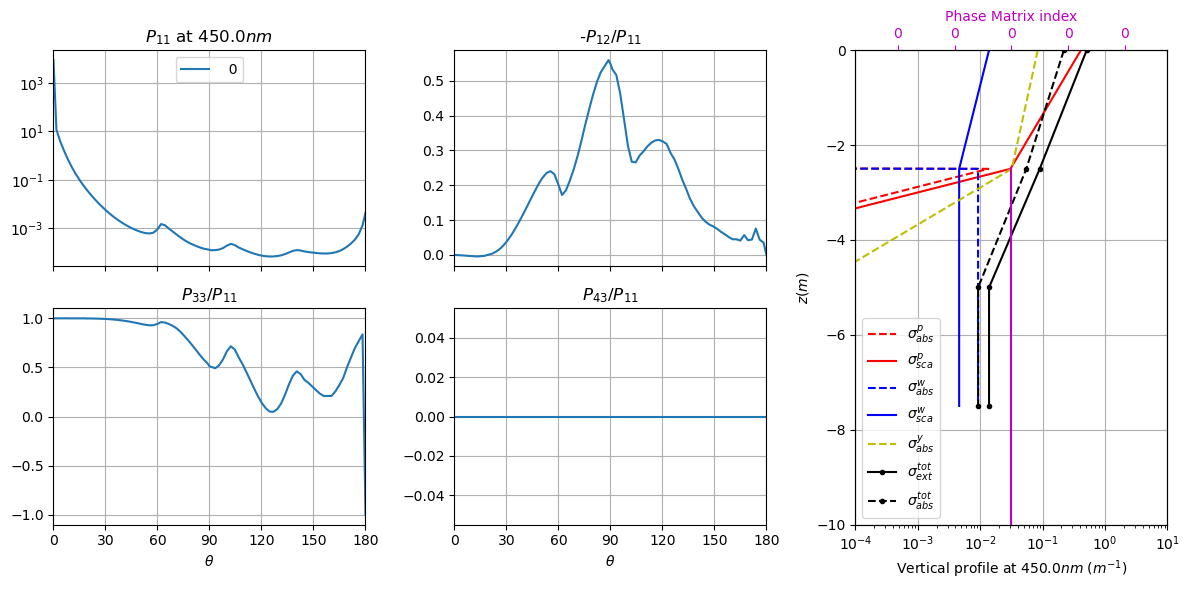

In [32]:
fig = input_view(m1,  kind='oc', iw=0, zmax=-10)

## Absorption

### Monochromatic absorption

Box(children=(FloatProgress(value=0.0, max=1000000000.0), Label(value='')), layout=Layout(align_items='center'…

Box(children=(FloatProgress(value=0.0, max=1000000000.0), Label(value='')), layout=Layout(align_items='center'…

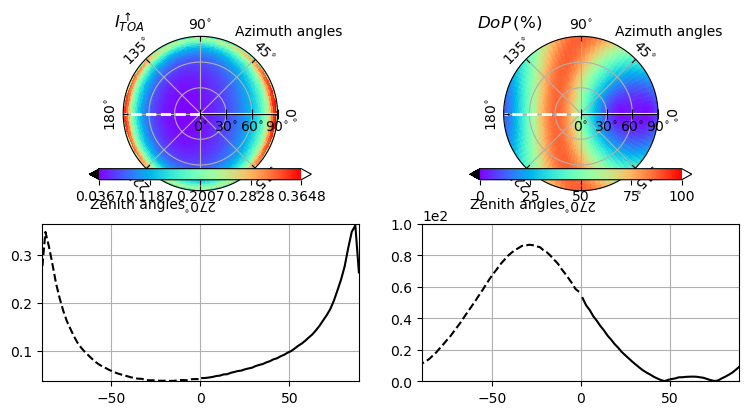

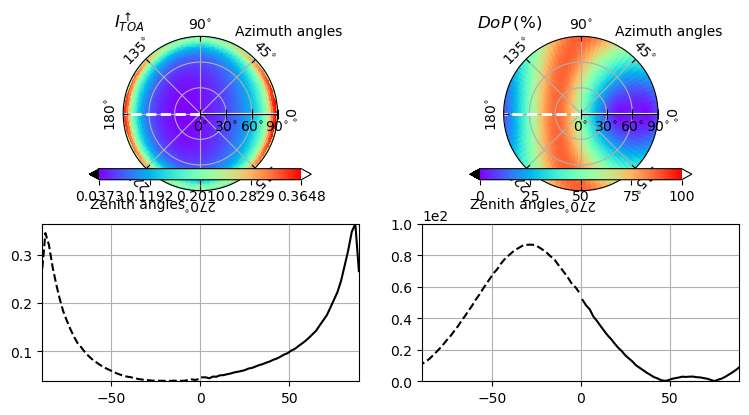

In [21]:
# standard gaseous absorption with ozone and NO2
# we use the single scattering albedo (ssa) method for computing absorption (BEER=0)
# this is the default method
atm = AtmAFGL('afglms', O3=300., NO2=True
             # optionally import gaseous absorption vertical profile
             #,prof_abs= gas_profile
              )
_ = smartg_view(Smartg().run(THVDEG=60., wl=550., NBPHOTONS=1e9, atm=atm, BEER=0))
# we can also use the equivalent theorem (Beer Lambert law) method for computing absorption (BEER=1)
_ = smartg_view(Smartg().run(THVDEG=60., wl=550., NBPHOTONS=1e9, atm=atm, BEER=1))

### Band gaseous absorption using REPTRAN
<br> REPTRAN is described in Gasteiger et al., 2014 and the data is available at www.libradtran.org <br>
J. Gasteiger, C. Emde, B. Mayer, R. Buras, S.A. Buehler, O. Lemke, Representative wavelengths absorption parameterization applied to satellite channels and spectral bands, Journal of Quantitative Spectroscopy and Radiative Transfer, Volume 148, November 2014, Pages 99-115, ISSN 0022-4073, http://dx.doi.org/10.1016/j.jqsrt.2014.06.024.

#### Example 1: Computation of reflectance in MSG-SEVIRI VIS08 channel

b'msg1_seviri_ch016'
b'msg1_seviri_ch006'


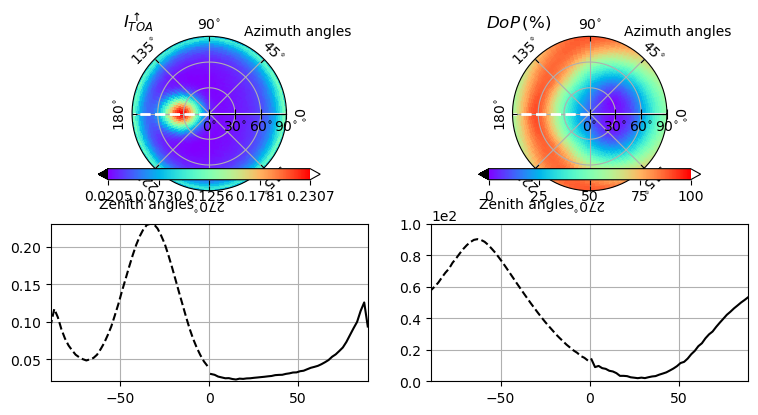

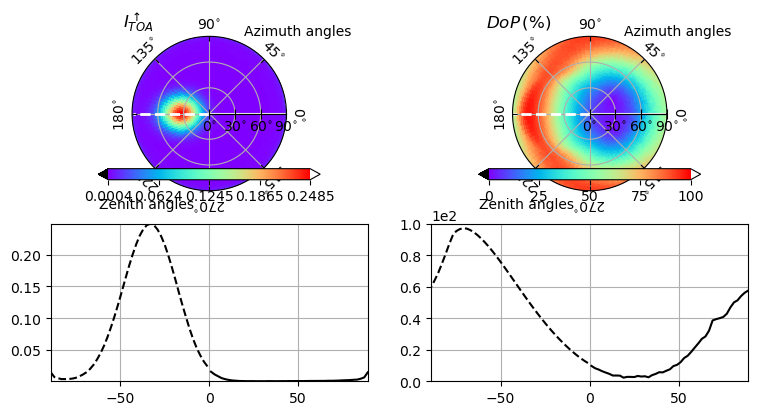

In [34]:
# REPTRAN k distribution file here MSG/SEVIRI solar channels
SEVIRI_SOLAR = REPTRAN('reptran_solar_msg')

# several ways of selecting bands
# 1) selecting all bands 
ibands = SEVIRI_SOLAR.to_smartg()
# 2) selecting one specific band
ibands = SEVIRI_SOLAR.to_smartg(include='msg1_seviri_ch008')
# 3) selecting all bands that contains "msg1" in the band name
ibands = SEVIRI_SOLAR.to_smartg(include='msg1')
# 4) selecting all bands whose wavelengths of internal bands satisfy the min and max conditions
ibands = SEVIRI_SOLAR.to_smartg(lmax=700.)
# 5) a mix of 3) and 4)
ibands = SEVIRI_SOLAR.to_smartg(include='msg1', lmin=600., lmax=1000.)
# 6) note that lmin and lmax can be lists (they should have the same length)
ibands = SEVIRI_SOLAR.to_smartg(include='msg1', lmin=[600., 1400.], lmax=[700., 2000.])

surf= RoughSurface(SUR=1, WIND=5., NH2O=1.34) 
atm = AtmAFGL('afglms', H2O=4.)

# Run Smart-g for Reptran list of ibands
m1  = Smartg(double=True).run(THVDEG=30, wl=ibands.l, NBPHOTONS=1e9, atm=atm, surf=surf, BEER=1, progress=False)

# Postprocessing: regrouping internal bands information into real band (spectral integration)
m1r = reduce_reptran(m1, ibands)

# Plotting bands 
for i,w in enumerate(m1r.axis('wavelength')):
    # we use for that a subset of m1r MLUT
    _ = smartg_view(m1r.sub(d={'wavelength':i}), ind=Idx([0.]))
    print(ibands.get_names()[i])

#### Example 2: Polarized reflectance in O2A band in sun glint view with Local Estimate

In [22]:
%%time
# k distribution file, here full solar channels at coarse resolution
SOLAR_COARSE = REPTRAN('reptran_solar_coarse')
ibands = SOLAR_COARSE.to_smartg(lmin=757., lmax=770.) # within O2A bands
surf=RoughSurface(SUR=1, WIND=5., NH2O=1.34)
atm=AtmAFGL('afglms', P0=900., comp=[AerOPAC('continental_average',1.,764.)], pfwav=[764.])
# Evaluate reflectance in specific direction Ths=[60.] and RAA=[180.] using LE
# dict containig directions vectors in radians and coded as float32
le={}
le.update(th =np.array([60.], dtype=np.float32)*np.pi/180)
le.update(phi=np.array([180.],dtype=np.float32)*np.pi/180)

Spp_mult=Smartg(double=True)

CPU times: user 709 ms, sys: 8.23 ms, total: 717 ms
Wall time: 778 ms


In [23]:
%%time
# Compute first atmosphere profiles at all wavelengths and phase functions for re-use
atmbase=atm.calc(ibands.l)

CPU times: user 203 ms, sys: 244 ms, total: 447 ms
Wall time: 449 ms


CPU times: user 7.09 s, sys: 124 ms, total: 7.21 s
Wall time: 7.21 s


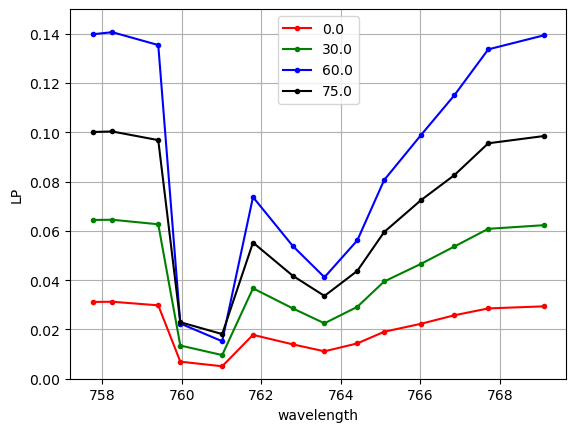

In [24]:
%%time
# Several runs: it goes faster as long as atmosphere does not change
for col,th0 in zip(['r','g','b','k'],[0.,30.,60.,75.]):
    # we use the single scattering albedo (ssa) method for computing absorption (BEER=0)
    # this is the default method
    m2_ssa = Spp_mult.run(THVDEG=th0, wl=ibands.l, NBPHOTONS=1e7, BEER=0, atm=atmbase, surf=surf, 
                          le=le, progress=False)
    m2r_ssa = reduce_reptran(m2_ssa, ibands)
    I=m2r_ssa['I_up (TOA)']
    Q=m2r_ssa['Q_up (TOA)']
    U=m2r_ssa['U_up (TOA)']

    LP = (Q*Q + U*U).apply(np.sqrt, 'LP')
    P = (LP/I*100).apply(np.abs,'DoLP')
    LP.sub()[:,0,0].plot(fmt='.-'+col,vmin=0, vmax=0.15, label=str(th0))
plt.legend(loc='best')

#### Example 3: Computation of Sentinel3/OLCI spectrum

In [44]:
SPP=Smartg()

# REPTRAN k distribution file here Sentinel 3 solar channels
SENTINEL_SOLAR = REPTRAN('reptran_solar_sentinel')
ibands = SENTINEL_SOLAR.to_smartg(include='olci') # select OLCI bands

th0=50.
le={}
le.update(th=np.array([th0],dtype=np.float32)*np.pi/180)
le.update(phi=np.array([150.],dtype=np.float32)*np.pi/180)
atm=AtmAFGL('afglms',      pfwav=[400., 700., 1000., 1300., 1600, 1900., 2200.])

water=IOP_1(1., DEPTH=50., pfwav=[400., 700.])

surf=RoughSurface()

# full simulation
m_wsa=reduce_reptran(SPP.run(THVDEG=th0, wl=ibands.l,  le=le, atm=atm , surf=surf, water=water, BEER=1,
             progress=True, OUTPUT_LAYERS=3, NBPHOTONS=1e8), ibands)

# just water
m_w= reduce_reptran(SPP.run(THVDEG=th0, wl=ibands.l,  le=le,  atm=None, surf=None, water=water, BEER=1,
             progress=True, OUTPUT_LAYERS=3, NBPHOTONS=1e8,), ibands)

# just surface
m_s= reduce_reptran(SPP.run(THVDEG=th0, wl=ibands.l,  le=le,  atm=None, surf=surf, water=None,  BEER=1,
             progress=True, OUTPUT_LAYERS=3, NBPHOTONS=1e8,), ibands)

# no atmosphere
m_ws=reduce_reptran(SPP.run(THVDEG=th0, wl=ibands.l,  le=le,  atm=None, surf=surf, water=water, BEER=1,
             progress=True, OUTPUT_LAYERS=3, NBPHOTONS=1e8,), ibands)

Box(children=(FloatProgress(value=0.0, max=100000000.0), Label(value='')), layout=Layout(align_items='center',…

Box(children=(FloatProgress(value=0.0, max=100000000.0), Label(value='')), layout=Layout(align_items='center',…

Box(children=(FloatProgress(value=0.0, max=100000000.0), Label(value='')), layout=Layout(align_items='center',…

Box(children=(FloatProgress(value=0.0, max=100000000.0), Label(value='')), layout=Layout(align_items='center',…

* plots in the perspective of atmospheric corrections

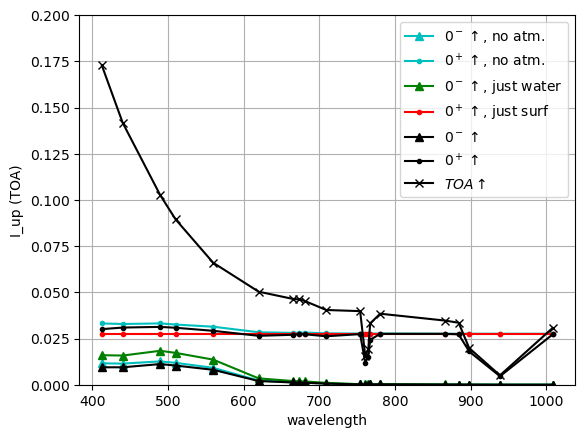

In [45]:
m_ws['I_up (0-)'].sub()[:,0,0].plot( fmt='c^-', label=r'$0^-  \uparrow$, no atm.')
m_ws['I_up (0+)'].sub()[:,0,0].plot( fmt='c.-', label=r'$0^+  \uparrow$, no atm.')

m_w['I_up (0-)'].sub()[:,0,0].plot( fmt='g^-', label=r'$0^-  \uparrow$, just water')

m_s['I_up (0+)'].sub()[:,0,0].plot( fmt='r.-', label=r'$0^+  \uparrow$, just surf',)

m_wsa['I_up (0-)'].sub()[:,0,0].plot( fmt='k^-', label=r'$0^-  \uparrow$')
m_wsa['I_up (0+)'].sub()[:,0,0].plot( fmt='k.-', label=r'$0^+  \uparrow$')
m_wsa['I_up (TOA)'].sub()[:,0,0].plot(fmt='kx-', label=r'$TOA \uparrow$', vmax=0.2,vmin=0)
plt.legend(loc='best')

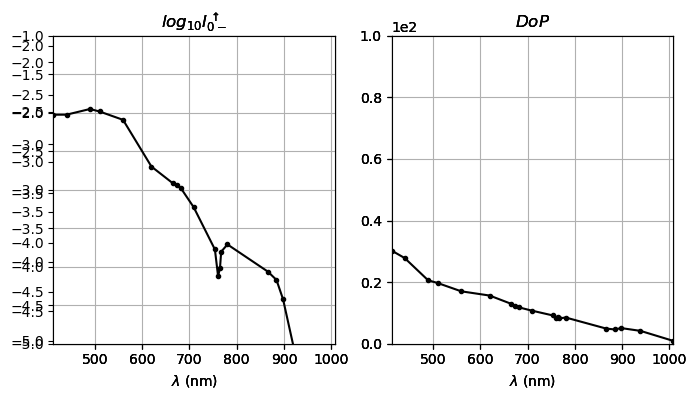

In [46]:
f=spectrum_view(m_w.sub({'Zenith angles':0,'Azimuth angles':0}), field='up (0-)',  color='r', fmt='.-', logI=True)
_=spectrum_view(m_ws.sub({'Zenith angles':0,'Azimuth angles':0}), field='up (0-)', color='b', fmt='.-', logI=True,
                fig=f)
_=spectrum_view(m_wsa.sub({'Zenith angles':0,'Azimuth angles':0}), field='up (0-)',color='k', fmt='.-', logI=True,
                fig=f, vmax=-1,vmin=-5)

#### S2-MSI spectral response functions

In [ ]:
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline
SRF = pd.read_excel(ROOTPATH + '/smartg/validation/Sentinel-2A MSI Spectral Responses.xlsx',
                   sheet_name='Spectral Responses')
w=np.array(SRF['SR_WL'])
winf=[]
wsup=[]
wmedian=[]
w_l=np.array([])
srf_l=np.array([])

for b,srf in enumerate(SRF):
    y=np.array(SRF[srf])
    if b!=0 :
        # edge detection for Filter wavelength boundaries
        # Get a function that evaluates the linear spline at any x
        f = InterpolatedUnivariateSpline(w, y, k=1)
        # Get a function that evaluates the derivative of the linear spline at any x
        dfdw =  f.derivative()
        dydw =  dfdw(w)

        ok=np.where(abs(dydw)>0.0001) # detect edges for SRFs with a threshold on first derivative
        plt.plot(w[ok],y[ok])
        #store boundaries of filter for further reptran, add a 2 nm margin
        w0=w[ok[0][0]]-2
        w1=w[ok[0][-1]]+2
        winf.append(w0)
        wsup.append(w1)
        wmedian.append((w0+w1)/2.)
print(SRF.columns.tolist()[1:])
print(winf,wsup)

In [ ]:
#1) use reptran with solar regular wavelength grid
SOLAR_COARSE = REPTRAN('reptran_solar_coarse')
ibands = SOLAR_COARSE.to_smartg(lmin=winf, lmax=wsup)

#2) use reprtran parametrization for S2/MSI channels directly
SENTINEL_SOLAR = REPTRAN('reptran_solar_sentinel')
ibands2 = SENTINEL_SOLAR.to_smartg(include='sentinel2a') # select S2/MSI bands
atm=AtmAFGL('afglms', pfwav=[400., 800., 1200., 1600., 2200.])
surf=RoughSurface()
le={}
th = np.linspace(0., 60.,  num=6, dtype=np.float32)
phi= np.linspace(0., 180., num=9, dtype=np.float32)
le.update(th =th *np.pi/180)
le.update(phi=phi*np.pi/180)
Spp_mult=Smartg()

In [ ]:
%%time
# Compute first atmospheric profiles at all wavelengths and phase functions for re-use
atmbase=atm.calc(ibands.l)

In [ ]:
%%time
# Run Smart-g for Reptran list of ibands and reduce
m  = reduce_reptran(Spp_mult.run(THVDEG=60, wl=ibands.l, NBPHOTONS=1e6, le=le, surf=surf, BEER=1, atm=atmbase), ibands)

In [ ]:
%%time
# Run directly smart-g without atmospheric pre computations
# Run Smart-g for Reptran list of ibands2 and reduce
m2  = reduce_reptran(Spp_mult.run(THVDEG=60, wl=ibands2.l, NBPHOTONS=1e6, le=le, surf=surf, BEER=1, atm=atm), ibands2)

In [ ]:
# final multiplication with SRFs
print('--------------------------------------')
print('REPTRAN SPECTRUM OUTPUT')
print('--------------------------------------')
m.describe()
wr=m.axis('wavelength') # reptran wavelength grid
MLUTS=[]
for b,srf in enumerate(SRF.columns.tolist()[1:]):
    y=np.array(SRF[srf])
    # interpolate SRFs to reptran wavelengths
    f = InterpolatedUnivariateSpline(w, y, k=1)
    fr= LUT(f(wr), axes=[wr], names=['wavelength'])
    ml = MLUT()
    for l in m:
        for pref in ['I_','Q_','U_','V_','transmission'] :
            if pref in l.desc:
                norm= fr.reduce(np.mean,'wavelength')
                lr = (l * fr).reduce(np.mean,'wavelength', as_lut=True)/norm
                ml.add_lut(lr, desc=l.desc )
    ml.set_attrs(m.attrs)
    ml.set_attr('median wavelength', wmedian[b])
    ml.set_attr('band', b+1)

    MLUTS.append(ml)
ms2 = merge(MLUTS, ['median wavelength'])
ms2.add_axis('band', np.arange(len(wmedian))+1)
print('')
print('--------------------------------------')
print('S2 CHANNELS OUTPUT')
print('--------------------------------------')
ms2.describe()
print('')
print('--------------------------------------')
print('REPTRAN S2 CHANNELS OUTPUT')
print('--------------------------------------')
ms2.describe()

m['I_up (TOA)'].sub()[:,Idx(160),Idx(50)].plot(fmt='g.',vmin=0, vmax=0.3, label=r'$TOA^\uparrow$ : Reptran coarse')
ms2['I_up (TOA)'].sub()[:,Idx(160),Idx(50)].plot(fmt='r^-', vmax=0.3, label=r'$TOA^\uparrow$ : Reptran coarse + S2 SRFs')
m2['I_up (TOA)'].sub()[:,Idx(160),Idx(50)].plot(fmt='bv:', vmax=0.3, label=r'$TOA^\uparrow$ : Reptran S2')
plt.legend()

In [ ]:
for i,(b,col) in enumerate(zip(wmedian, ['r','b','g','c']*2)):
    if i==0:
        fig=transect_view(ms2.sub(d={'median wavelength':i}), ind=Idx(180), logI=True, color='k', fmt='-')    
    _=transect_view(ms2.sub(d={'median wavelength':i}), ind=Idx(180), logI=True, fig=fig, color=col, fmt='-')
    _=transect_view(m2.sub(d={'wavelength':i}), ind=Idx(180), logI=True, fig=fig, color=col,  fmt=':')

### High Spectral Resolution gaseous absorption using HITRAN
<br> HITRAN online API interface (HAPI) in python is used. Sources are availabe at http://hitran.org/hapi/.
<br>R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski, HITRAN Application Programming Interface (HAPI): A comprehensive approach to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
<br> **It is recommended to use ALIS to avoid spectral MC noise (see advanced ALIS notebook)**

#### Polarized radiances in the O2A band

## BRDF

### Ross-Thick Li-Sparse kernel

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

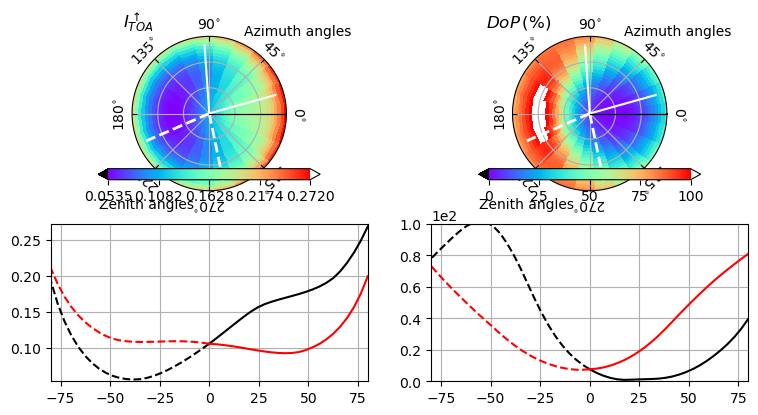

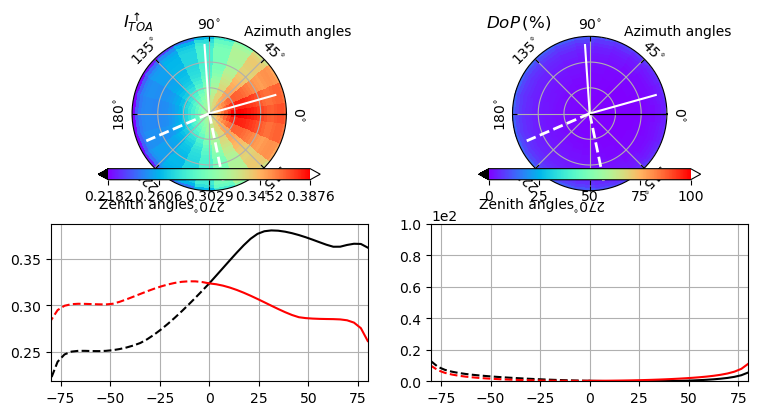

In [49]:
##### Spectral RTLS BRDF ######
#Definition of a Ross-Thick Li-Sparse reflector
#K0, K1, K2 are the 3 coefficients of:
#K0 : Spectral Albedo of the isotropic (lambertian) kernel
#K1 : Spectral weight the F1 (geometric) kernel 
#K2 : Spectral weight the F2 (volumetric) kernel
#--------------
# in SMART-G the RTLSSurface() objects is initialized with:
#kp = (k0 , k1p, k2p): a tuple of
#k0 : Spectral Albedo of the isotropic (lambertian) kernel
#k1p: Spectral relative weight the F1 (geometric) kernel (=K1/K0)
#k2p: Spectral relative weight the F2 (volumetric) kernel(=K2/K0)
######################
KVIS = (0.06, 0.05, 0.3) # vegetation in VIS
KPVIS= (KVIS[0], KVIS[1]/KVIS[0], KVIS[2]/KVIS[0])
KNIR = (0.36, 0.05, 0.3) # vegetation in NIR
KPNIR= (KNIR[0], KNIR[1]/KNIR[0], KNIR[2]/KNIR[0])
wl   = np.array([440., 760.])
kp   = (Albedo_spectrum(np.array([KPVIS[0],KPNIR[0]]), wl), 
        Albedo_spectrum(np.array([KPVIS[1],KPNIR[1]]), wl),
        Albedo_spectrum(np.array([KPVIS[2],KPNIR[2]]), wl))
surf = RTLSSurface(kp=kp)
atm  = AtmAFGL('afglt')
# atmosphere + surface
azimuth_transect = (10.,90)
N  = 24
le = {'th_deg': np.linspace(0, 80., num=N), 'phi_deg': np.linspace(360., 0., num=N), 'zip':False}
m  = Smartg().run(wl, NBPHOTONS=1e6, THVDEG=25., le=le, atm=atm, surf=surf)
fig= smartg_view(m, ind=Idx(azimuth_transect), QU=False, subdict={'wavelength':0})
fig= smartg_view(m, ind=Idx(azimuth_transect), QU=False, subdict={'wavelength':1})

## Irradiances

In [50]:
Spp  = Smartg()
surf = RoughSurface(SUR=3, WIND=10., NH2O=1.34)
atm  = AtmAFGL('afglms')
water= IOP_1(chl=1.1, pfwav=[550.], DEPTH=100.) 
wl   = np.linspace(400., 700., num=11)
TH0  = 75.

In [51]:
# 1) planar and spherical fluxes using the "flux" keyword
# Flux are computed FAST in Cone sampling mode
NB=1e7
P = Spp.run(THVDEG=TH0, wl=wl, NBPHOTONS=NB, atm=atm, surf=surf, water=water,
                 flux='planar', OUTPUT_LAYERS=3)
S = Spp.run(THVDEG=TH0, wl=wl, NBPHOTONS=NB, atm=atm, surf=surf, water=water, 
                 flux='spherical', OUTPUT_LAYERS=3)

# 2) fluxes could be recomputed from radiances, with care about the directional sampling and statistics
# in general, longer and less accurate
M  = Spp.run(THVDEG=TH0, wl=wl, NBPHOTONS=NB, atm=atm, NBTHETA=360, NBPHI=360, surf=surf, water=water, OUTPUT_LAYERS=3)
# directional integration for irradiances
Mr = reduce_Irr(M)

Box(children=(FloatProgress(value=0.0, max=10000000.0), Label(value='')), layout=Layout(align_items='center', …

Box(children=(FloatProgress(value=0.0, max=10000000.0), Label(value='')), layout=Layout(align_items='center', …

Box(children=(FloatProgress(value=0.0, max=10000000.0), Label(value='')), layout=Layout(align_items='center', …

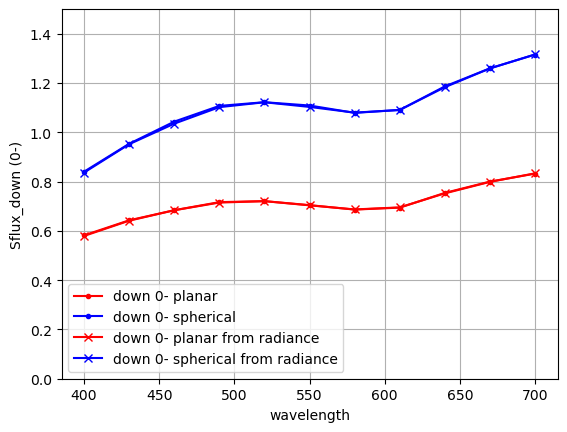

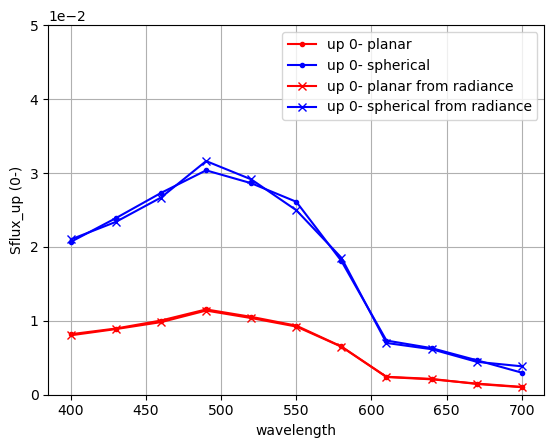

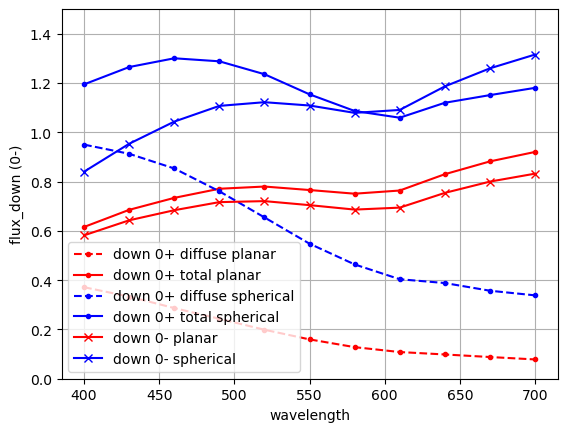

In [52]:
# plot downward fluxes spectra just underwater 
P['flux_down (0-)'].plot(fmt='r.-',vmin=0,vmax=1.5,label='down 0- planar')
S['flux_down (0-)'].plot(fmt='b.-',vmin=0,vmax=1.5,label='down 0- spherical')
Mr['Pflux_down (0-)'].plot(fmt='rx-',vmin=0,vmax=1.5,label='down 0- planar from radiance')
Mr['Sflux_down (0-)'].plot(fmt='bx-',vmin=0,vmax=1.5,label='down 0- spherical from radiance')
plt.legend(loc='best')
# plot upward fluxes spectra just underwater 
plt.figure()
P['flux_up (0-)'].plot(fmt='r.-',vmin=0,vmax=0.05,label='up 0- planar')
S['flux_up (0-)'].plot(fmt='b.-',vmin=0,vmax=0.05,label='up 0- spherical')
Mr['Pflux_up (0-)'].plot(fmt='rx-',vmin=0,vmax=0.05,label='up 0- planar from radiance')
Mr['Sflux_up (0-)'].plot(fmt='bx-',vmin=0,vmax=0.05,label='up 0- spherical from radiance')
plt.legend(loc='best')

# 3) For the particular "Down (0+)" Irradiance, it contains only Diffuse component, the direct component
# is obtained trough the 'direct transmission' field
T = P['direct transmission']
plt.figure()
P['flux_down (0+)'].plot(fmt='r.--',vmin=0,vmax=1.5,label='down 0+ diffuse planar')
(P['flux_down (0+)']+T).plot(fmt='r.-',vmin=0,vmax=1.5,label='down 0+ total planar')
S['flux_down (0+)'].plot(fmt='b.--',vmin=0,vmax=1.5,label='down 0+ diffuse spherical')
(S['flux_down (0+)']+T).plot(fmt='b.-',vmin=0,vmax=1.5,label='down 0+ total spherical')
P['flux_down (0-)'].plot(fmt='rx-',vmin=0,vmax=1.5,label='down 0- planar')
S['flux_down (0-)'].plot(fmt='bx-',vmin=0,vmax=1.5,label='down 0- spherical')
plt.legend(loc='best')


## Thermal source (dev)

In [53]:
#REPTRAN k distribution file here MSG/SEVIRI1 thermal channels
from smartg.reptran import Reptran_Emission, Reptran_Avg_Emission
SEVIRI_THERMAL = REPTRAN('reptran_thermal_msg')

Box(children=(FloatProgress(value=0.0, max=100000000.0), Label(value='')), layout=Layout(align_items='center',…

Box(children=(FloatProgress(value=0.0, max=100000000.0), Label(value='')), layout=Layout(align_items='center',…

Box(children=(FloatProgress(value=0.0, max=100000000.0), Label(value='')), layout=Layout(align_items='center',…

Box(children=(FloatProgress(value=0.0, max=100000000.0), Label(value='')), layout=Layout(align_items='center',…

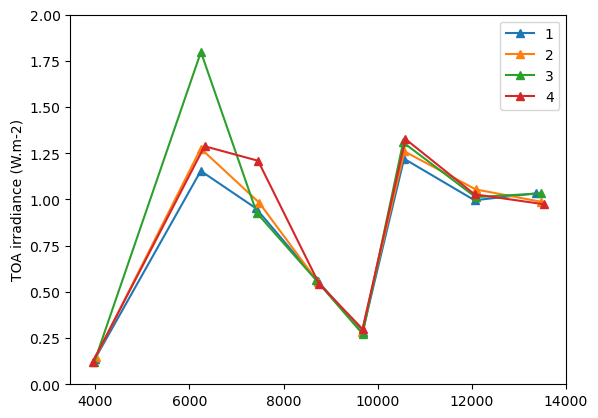

In [54]:
# Compile with thermal option
# Only in forward mode for the moment, no ground
ST = Smartg(thermal=True, alt_pp=True, back=False)
for platform in ['1','2','3','4']:
    ibands         = SEVIRI_THERMAL.to_smartg(include='msg'+platform)
    atm            = AtmAFGL('afglt', grid=np.linspace(50, 0, num=51))
    prof_atm       = atm.calc(ibands.l)
    # DIRECT option activated i.e direct transmitted radiance form source to receiver counted
    # (as opposite to solar computation where the direct light is not counted)
    # cell_proba has to be set to 'auto' : Distribution of thermal source within the atmosphere set automatically
    fl = ST.run(DIRECT=True, wl=ibands.l, flux='planar', NBPHOTONS=1e8, atm=prof_atm, cell_proba='auto')
    # The Column integrated thermal Emission is computed using the function Avg_Emission
    # is it used in the reduce final computation
    fl_int = reduce_reptran(fl, ibands, integrated=True,  extern_weights=Reptran_Avg_Emission(prof_atm, ibands))
    plt.errorbar(fl_int.axis('wavelength'),
              fl_int['flux_up (TOA)'].data,
              label=platform, marker='^')
plt.ylim(0,2)
plt.ylabel('TOA irradiance (W.m-2)')
plt.legend()

## Looping over parameters

In [ ]:
# loop over Aerosol Optical Thickness
MLUTS = []
Spp=Smartg()
for aot in np.linspace(0, 1.5, 5):
    M = Spp.run(THVDEG=30.,
               wl=443., NBPHOTONS=1e7,
               atm=AtmAFGL('afglt',comp=[AerOPAC('desert',aot,443.)]),
               surf=RoughSurface(WIND=5.))
    M.set_attr('AOT', aot) # to define a new axis 'aot' later
    MLUTS.append(M)

In [ ]:
#Merge all previous looped MLUTs into a single one
M = merge(MLUTS, ['AOT'], dtype=float)
M.describe()

In [ ]:
M[0].sub()[:,Idx(90),Idx(45)].plot(fmt='o-')

## Difference between two LUTs

In [ ]:
%%time
# Here we compare the TOA radiance simulated with
# plane parallel and spherical atmospheres, at 400 nm.
atm=AtmAFGL('afglt', O3=0., NO2=False)
ths = np.concatenate((
            np.linspace(0. ,75., num=12, dtype=np.float32),
            np.linspace(76.,89., num=12, dtype=np.float32)))
le={}
le.update(th_deg = ths)
le.update(phi_deg= np.array([0.,180.], dtype=np.float32))

Spp=Smartg(pp=True,   double=True, back=True, alt_pp=True)
Ssp=Smartg(pp=False,  double=True, back=True)

# show relative difference
plt.figure(figsize=(6,6))
results = []
for S in [Spp, Ssp]:
    results.append(S.run(RTER= 6370., THVDEG=30., wl=400., NBPHOTONS=5e7, le=le, atm=atm, stdev=True))

PP = results[0]['I_up (TOA)'].sub()[Idx(0),:]
SP = results[1]['I_up (TOA)'].sub()[Idx(0),:]
PP_std = results[0]['I_stdev_up (TOA)'].sub()[Idx(0),:]
SP_std = results[1]['I_stdev_up (TOA)'].sub()[Idx(0),:]
diff = 100.*(PP-SP)/SP
diff.desc = 'Plane Parallel - Spherical (%)'
(diff).plot(fmt='.:', vmin=-3., vmax=3.)
unc = ((SP_std*SP_std/SP/SP) + (PP_std*PP_std/PP/PP)).apply(np.sqrt,'uncertainty')*100
plt.errorbar(diff.axis('Zenith angles'), diff[:], yerr=unc[:], fmt='none')

## Interactive simulation

In [ ]:
from ipywidgets import interact, interact_manual

S=Smartg()
le={}
le={}
le.update(phi=np.array([0.]),dtype=np.float32)
le.update(th=np.array([60.])*np.pi/180,dtype=np.float32)

def simulate(thvdeg, surface, aerosol_model, aot550):
    surf = {True:RoughSurface(), False:None}[surface]
    aer = AerOPAC(aerosol_model, aot550, 550.)
    print('TOA Intensity : %.5f'%S.run(THVDEG=thvdeg,
             wl=[443.], NBPHOTONS=1e5, le=le,
             atm=AtmAFGL('afglt', comp=[aer]), surf=surf, progress=False
          )['I_up (TOA)'].data)

interact_manual(simulate, thvdeg=(0, 90), surface=True,
                aerosol_model= AerOPAC('desert', 0.1, 550.).list(), aot550=(0.0, 5., 0.05)
                )

# Backward mode and Sensor class

## Limb geometry

In [4]:
%%time
# Backward mode is needed when the scene is not invariant by horizontal translation anymore
# e.g. spherical shell atmosphere or horizontally varying surface reflectance
# In that case, the keyword back=True should be used for compilation 
# (the bias sampling scheme for scattering (default) is mandatory, bias=True)
# Here the example deals with spherical shell atmosphere (pp=False)
S = Smartg(back=True, pp=False, double=True)
# in backward mode, photons are injected FROM the sensor, and the outputs correspond to solar geometries
# So we define where the sensor is located with the Sensor class
# in this example, the sensor is placed at the TOA and is looking at the limb
HTOA = 120.
RTER = 6371. # Earth's radius
wl   = [430., 660., 840.]
#
#
grid    = np.linspace(HTOA, 0., num=51)
atm1  = AtmAFGL('afglsw', grid=grid)

# lambertian surface
ALB  = Albedo_cst(0.1)
surf = LambSurface(ALB=ALB)

def zt2thv(zt, RTER=6371., HTOA=120.):
    return np.arcsin((RTER+zt)/(RTER+HTOA))*180/np.pi
# For a vertical profile in backward mode, several sensors are needed
# we make a loop on trigonometric tangent heights and also viewing azimuths
# and make a LIST of sensors

from itertools import product
sensors= []
NT = 16 # number of tangent heights
NP = 4 # relative azimuths to the sun
ZT   = np.linspace(2., 50,  num=NT)
DPHI = np.linspace(0., 91, num=NP)
for zt,dphi in product(ZT, DPHI):
    sensors.append( 
                # sensor object creation
                Sensor(POSX = 0.,   # Sensor coordinates (in km) (default:origin(0.,0.,0.))
                POSY = 0.,
                POSZ = HTOA+RTER,   # in spherical mode set Z to the distance from Earth center, 
                                    # in PP, Z is the altitude
                THDEG= 180.-zt2thv(zt, HTOA=HTOA),         
                                    # Sensor 'Emitting' zenith angle, from 0: Zenith,
                                           #  to 180.: Nadir (default:0.)
                PHDEG= dphi,        # Sensor 'Emitting' azimuth angle (default:0.)
                LOC  = 'ATMOS',     # location of sensor (default: (SURF0P, just above surface)
                FOV  = 0.,          # Sensor FOV (default 0.)
                TYPE = 0            # Sensor type :Radiance (0), Planar flux (1), 
                                           # Spherical Flux (2), (default 0)
                    )
               )    
NB = 2e5 * NT * NP # so 2e5 photons per sensor

ths    = np.array([60., 80., 91., 94.]) # different SZA
phis   = np.array([0.])
# Local estimate directions correspond to solar positions
le = {'th_deg':ths, 'phi_deg':phis}

# the sensor keyword accepts a list of sensor obsjects
m1  = S.run(wl=wl, surf=surf, le=le, atm=atm1, NBPHOTONS=NB, RTER=RTER, NF=1e5,
              refraction=True, sensor=sensors, reflectance=False)
# look at the result: a new dimension  'sensor index' is present in the MLUT

Box(children=(FloatProgress(value=0.0, max=12800000.0), Label(value='')), layout=Layout(align_items='center', …

CPU times: user 96.4 ms, sys: 450 ms, total: 547 ms
Wall time: 4.91 s


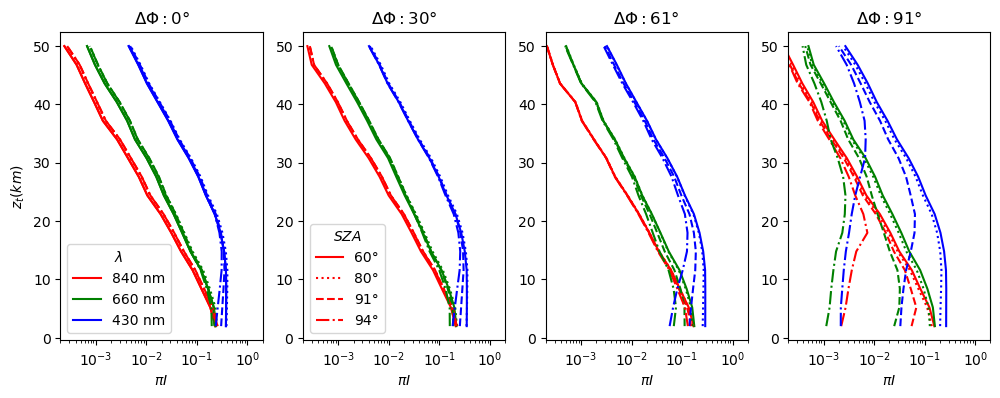

In [5]:
# You can get back a 2D output of intensities by reshaping to (NT, NP) what is inside the 'sensor index'
# dimension
col = ['r','g','b']
lin = ['-',':','--','-.']
fig,ax =plt.subplots(1,4)
fig.set_size_inches(12,4)

for i,(ts,l) in enumerate(zip(ths, lin)):
    for  j,dp in enumerate(DPHI):
        for k,(lam,c) in enumerate(zip(wl[::-1], col)):
            I1 = m1['I_up (TOA)']\
                   [:, Idx(lam, fill_value='extrapolate'), 0, Idx(ts)].reshape(NT,NP)
            if( i==0 and j==0) : ax[j].semilogx(I1[:,j], ZT, l, color=c, label='%.0f nm'%(lam))
            if( k==0 and j==1) : ax[j].semilogx(I1[:,j], ZT, l, color=c, label='%.0f°'%(ts))   
            else               : ax[j].semilogx(I1[:,j], ZT, l, color=c)
        ax[j].grid()
        ax[j].set_xlim([0.0002, 2])
        ax[j].set_xlabel(r'$\pi I$')
        ax[j].set_title(r'$\Delta\Phi:%.0f$°'%dp)
    ax[0].set_ylabel(r'$z_t (km)$')
    ax[0].legend(title=r'$\lambda$')
    ax[1].legend(title=r'$SZA$')

## Horizontal inhomogeneity

In [6]:
# Goal: to simulate an observation from a satellite sensor 
# for 1 thv and several azimuths (Almucantar)
# with a straight coastline (limit ocean land at x=0, ocean for x <0)
# the sensor is looking to a water pixel located at a varying distance from the coastline
# we simulate a coastline as being the zone near a big circle, whose radius is 1e6 km
# centred on a point located far from the sensor (-1e6 km from the origin )
# The interior of the circle is the ocean
# Principal plane reflectance and DoLP for 380, 500 and 800 nm
wl      = [ 380., 500., 800.]
col     = ['b','g','r']

# Solar geometries in backward mode
nsaa    = 4
nsza    = 24
SZA_MAX = 70.
SAAs    = np.linspace(0., 270.,    num=nsaa, dtype=np.float32, endpoint=True)
SZAs    = np.linspace(0., SZA_MAX, num=nsza, dtype=np.float32, endpoint=True)
le      = {'th_deg':SZAs, 'phi_deg':SAAs}

aer     = AerOPAC('maritime_polluted', 0.3, 500.)
atm     = AtmAFGL('afglms', comp=[aer])
surf    = RoughSurface(WIND=5., BRDF=True) # Cox & Munk BRDF, time symetrical

VZA     = 30.
D       = 1.0e6 #(km)
# The Environement object creates a disk of ocean surface with radius ENV_SIZE
# centred on X0,Y0 , surrounded by lambertian reflector of albedo ALB
env     = Environment(ENV=1, 
                  ENV_SIZE= D ,       # radius of the circle with ocean surface condition
                  X0= -D,             # X coordinate of the center of the circle
                  Y0= 0,
                  ALB=Albedo_cst(0.5) # Lambertian grey albedo of the land zone (snow)
                 )
Sb      = Smartg(back=True,  double=True) ## Plane Parallel

In [7]:
%%time
HTOA  = 120.
VAAs  = [0., 90., 180., 270.] # 4 View Azimuth Angles; VAA=0 the sensor is 'above water'
dists = [0.250, 5., D]   # 3 distances to the coast (km)

sensors= []
cases  = list(product(VAAs, dists))
for VAA, dist in cases:
    # sensor is placed at the TOA and is looking down
    # to the point (-dist, 0., 0.) from several relative azimuths
    # to the coastline (VAA); 
    DeltaH = HTOA   * np.tan(np.radians(VZA))
    DeltaX = DeltaH * np.cos(np.radians(180-VAA))
    DeltaY = DeltaH * np.sin(np.radians(180-VAA))
    sensors.append(
            Sensor(
            POSX = -dist + DeltaX,      # Sensor coordinates (in km) (default:origin(0.,0.,0.))
            POSY = DeltaY,
            POSZ = HTOA,
            THDEG= 180-VZA, # Sensor 'Emitting' zenith angle, from 0: Zenith to 180.: Nadir (default:0.)
            PHDEG= VAA,     # Sensor 'Emitting' azimuth angle (default:0.)
            LOC  = 'ATMOS', # location of sensor (default: (SURF0P, just above surface)
            FOV  = 0.,      # Sensor FOV (default 0.)
            TYPE = 0        # Sensor type :Radiance (0), Planar flux (1), Spherical Flux (2), (default 0)
            )
    )
NB = 1e6 * len(VAAs) * len(dists)
m  = Sb.run(wl=wl, atm=atm, surf=surf, env=env, NBPHOTONS=NB, le=le, 
         sensor=sensors, progress=True)

Box(children=(FloatProgress(value=0.0, max=12000000.0), Label(value='')), layout=Layout(align_items='center', …

CPU times: user 1.38 s, sys: 4.19 s, total: 5.57 s
Wall time: 5.57 s


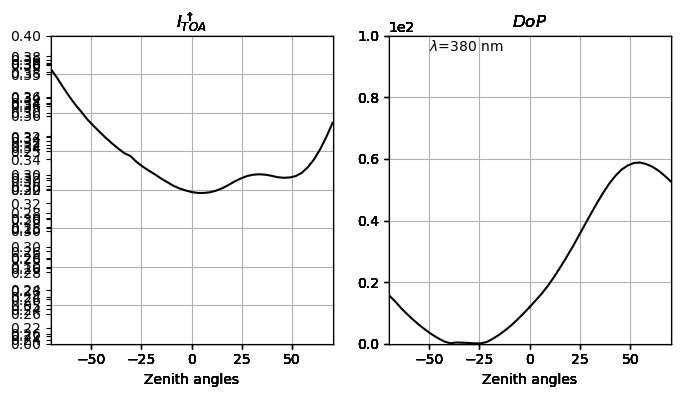

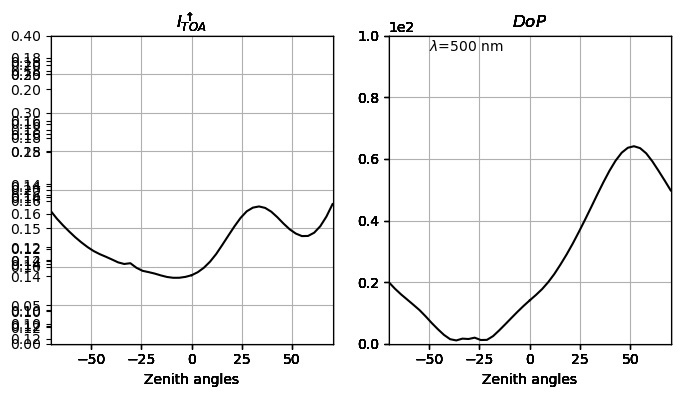

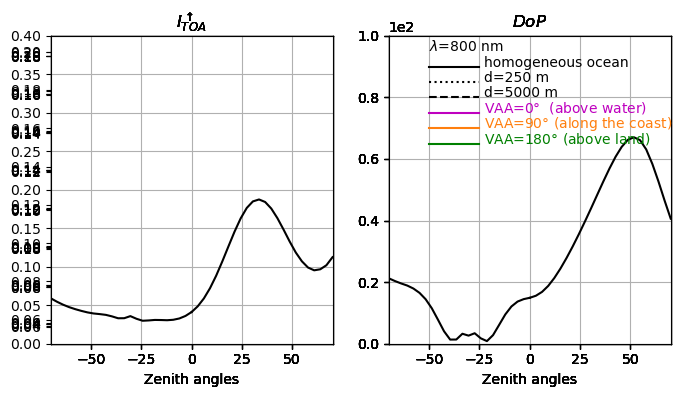

In [8]:
# the transects are plotted for RAA=0, (principal plane)
RAA = 0.

for i,w in enumerate(wl):
    # for VAA=0, the sensor is 'above water'
    VAA = VAAs[0]
    SAA = VAA - RAA
    ind = cases.index((VAA, dists[0])) # retrieving sensor index from the cases
    f=transect_view(m.sub(d={'sensor index':ind, 'wavelength':Idx(w)}), 
                    color='m', fmt=':', ind=Idx([SAA]) )
    ind = cases.index((VAA, dists[1]))
    _=transect_view(m.sub(d={'sensor index':ind, 'wavelength':Idx(w)}),
                    color='m', fmt='--',ind=Idx([SAA])   , fig=f)
    
    # for VAA=90, the sensor is 'above the coastline'
    VAA = VAAs[1]
    SAA = VAA - RAA
    ind = cases.index((VAA, dists[0]))
    _=transect_view(m.sub(d={'sensor index':ind, 'wavelength':Idx(w)}),
                    color='C1',fmt=':', ind=Idx([SAA]), fig=f)
    ind = cases.index((VAA, dists[1]))
    _=transect_view(m.sub(d={'sensor index':ind, 'wavelength':Idx(w)}),
                    color='C1',fmt='--',ind=Idx([SAA]), fig=f)

    # for VAA=180, the sensor is 'above land'
    VAA = VAAs[2]
    SAA = VAA - RAA
    ind = cases.index((VAA, dists[0]))
    _=transect_view(m.sub(d={'sensor index':ind, 'wavelength':Idx(w)}),
                    color='g', fmt=':', ind=Idx([SAA]), fig=f)
    ind = cases.index((VAA, dists[1]))
    _=transect_view(m.sub(d={'sensor index':ind, 'wavelength':Idx(w)}),
                    color='g', fmt='--',ind=Idx([SAA]), fig=f)
    
    # whatever VAA, the last distance is 1e6 km similar to the infinite homogeneous ocean case
    ind = cases.index((VAA, dists[-1]))
    _=transect_view(m.sub(d={'sensor index':ind, 'wavelength':Idx(w)}),
                    color='k', fmt='-', ind=Idx([SAA]), fig=f, vmin=0, vmax=.4)
    plt.text(-50.,95,r'$\lambda$=%.0f nm'%w)
    if i==2:
        plt.plot([-50,-25],[90,90],'k-')
        plt.text(-23,90,'homogeneous ocean')
        plt.plot([-50,-25],[85,85],'k:')
        plt.text(-23,85,'d=250 m')
        plt.plot([-50,-25],[80,80],'k--')
        plt.text(-23,80,'d=5000 m')
        plt.plot([-50,-25],[75,75],'m-')
        plt.text(-23,75,r'VAA=0$\degree$  (above water)', color='m')
        plt.plot([-50,-25],[70,70],'C1-')
        plt.text(-23,70,r'VAA=90$\degree$ (along the coast)', color='C1')
        plt.plot([-50,-25],[65,65],'g-')
        plt.text(-23,65,r'VAA=180$\degree$ (above land)', color='g')

## Albedo map

In [9]:
# A 2D horizontal map of spectral albedos can be constructed
# Spectral albedos are limited to a MAX_NREF=10 different kind, could be extended
# They should be defined using Albedo_cst, Albedo_spectrum or Albedo_speclib classes
Alb_list = [
           Albedo_speclib(ROOTPATH + '/smartg/validation/jhu.becknic.water.snow.granular.82um.medium.spectrum.txt'),
           Albedo_speclib(ROOTPATH + '/smartg/validation/jhu.becknic.soil.alfisol.paleustalf.coarse.87P473.spectrum.txt')
           ]
# The horizontal grid for the 2D map of albedo (ENV=5) is rectangular, centred on X0,Y0 keywords of the Environement object
# and x and y boundaries are encoded in monotonic np.arrays whose values are the upper limit of the rectangles:
# if x = [x0, x1, x2, ..., xn], the the limits are [-Inf, x0], [x0, x1], ..., [xn-1, xn], with xn should be big to be considered as +Inf 
# Example :  a land square of 20 km edge with two albedos (soil and snow) and large ocean zone from -Inf to -10km and +10km to +Inf
x = np.array([-10, 0, 10, 1e8])
y = np.array([-10, 10, 1e8])
# Then we assigned each rectangle an index in Alb_list, in a 2D array of shape (len(x),len(y))
# Example :  the map points to the ocean surface with seafloor soil albedo (surface : negative indices) for all rectangles 
# except the two central ones with land soil and snow albedos (environment : positive indices)
# Negative indices are for the surf properties instead of the 2D env albedos
surf = RoughSurface(WIND=5., WAVE_SHADOW=True)
water= IOP_1(chl=0.1, DEPTH=10., pfwav=[600.])
Ai  = np.array([[-1,-1,-1],[-1,0,-1],[-1,1,-1],[-1,-1,-1]])
#
# we build the Albedo 2D object
ALB = Albedo_map(Ai, x, y, Alb_list)
# Finally define the Environment object with this 2D albedo
env = Environment(ENV=5, X0=0, Y0=0, ALB=ALB)

In [10]:
# Let us simulate an image seen from Top and looking at nadir (in backward mode)
N  = 8
x0 = np.linspace(-10.1, 10.1, num=N, endpoint=True)
y0 = np.linspace(-10.1, 10.1, num=N, endpoint=True)
# building sensors list
sensors=[]
for a in x0:
        for b in y0:
                 sensors.append(Sensor(POSZ=120., POSX=a,  POSY=b, LOC='ATMOS', THDEG=180.))

# defining Sun's output direction
le = {'th_deg':np.array([60.]), 'phi_deg':np.array([0.]), 'zip':True}
atm  = AtmAFGL('afglt', comp=[AerOPAC('continental_clean', 0.3, 550.)], pfwav=[600.])
wl   = np.linspace(400., 900., num=9)
#
#RUN
res=Smartg().run(wl=wl, le=le, sensor=sensors, atm=atm, surf=surf, env=env, water=water, 
        NBPHOTONS=1e8, BEER=1, RR=0).dropaxis('Zenith angles')

Box(children=(FloatProgress(value=0.0, max=100000000.0), Label(value='')), layout=Layout(align_items='center',…

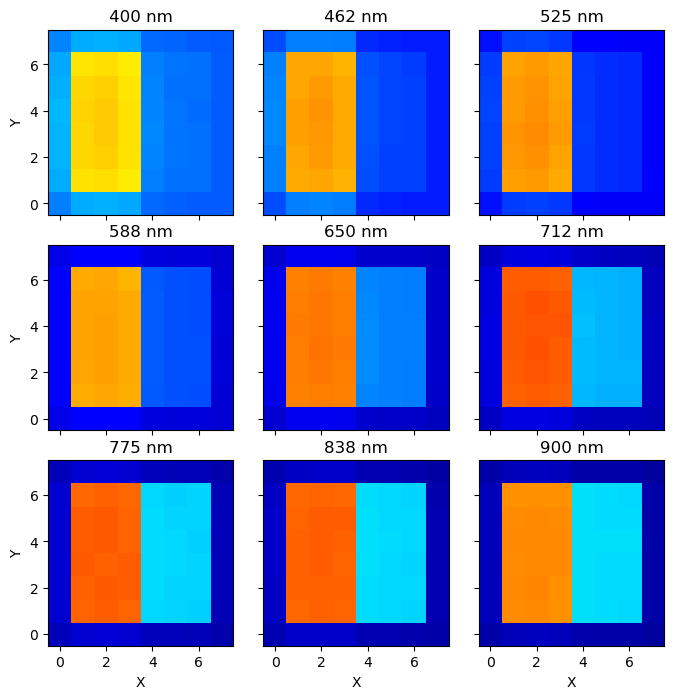

In [11]:
fig  = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),
                 axes_pad=0.3,
                 label_mode="L",
                 )
# images : loop on wavelength
for (ax, w, im) in zip(grid, wl, res['I_up (TOA)'].data.T):
    img = ax.imshow(im.reshape(N,N).T, origin='lower', vmin=0, vmax=1, cmap=plt.cm.jet)
    ax.set_title('%.0f nm'%w)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
#fig.colorbar()

# Histories

In [5]:
from smartg.histories import get_histories, BigSum, Si, Si2
# We give an example of outputing photon's histories in the alis method.
# This allows to compute various quantities jacobians relative to absorption or reflection

# see Multispectral example (output m3)
# We extract the absorption coefficient vertical profiles at high spectral resolution
kabs = od2k(m3, 'OD_abs_atm')[:,1:]

In [6]:
# Computations of histories are done on the low resolution grid
# !! NBLOOP and NBPHOTONS should be equal (one UNIQUE pass)
m4 = Salis.run(wl=wl_lr, le=le, alis_options={'nlow':wl_lr.size, 'hist':True},
           THVDEG=60., NBPHOTONS=NB, NBLOOP=NB,
           atm=pro.calc(wl_lr), OUTPUT_LAYERS=0,
           surf=surf).dropaxis('Zenith angles').dropaxis('Azimuth angles')

Box(children=(FloatProgress(value=0.0, max=300000.0), Label(value='')), layout=Layout(align_items='center', di…

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


CPU times: user 10.2 s, sys: 3.73 s, total: 13.9 s
Wall time: 2.57 s


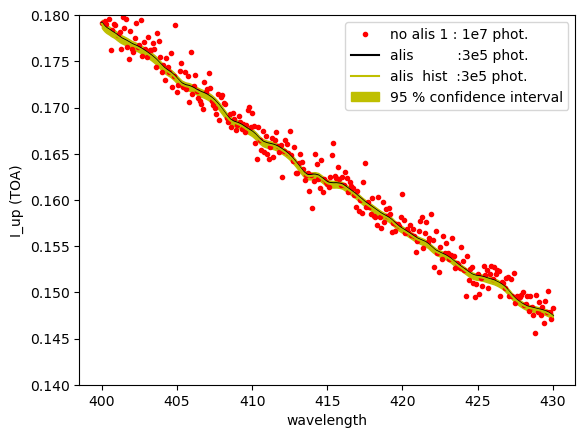

In [8]:
%%time
# we extract the photons main charactetisctics
'''
Output
    a tuple consisting of 
        N : the number of injected photons
        S : A ndarray of size (NLE, 4) for 4 Stokes components
        D : A ndarray of size (NLE, NL) for cumulative distances traveled in layers
        w : A ndarray of size (NLE, NLR) for corrective scattering weights for the different Low Resolution LR wavelengths
        nrrs : A ndarray of size (NLE) of Rotational Raman Scattering event flag (1 : RRS, 0: no RRS)
        nref : A ndarray of size (NLE) of number of reflection on the surface (as described by the keyword surf in the run method)
        nrrs : A ndarray of size (NLE) of Sun Induced Fluorescence event flag (1 : SIF, 0: no SIF)
        nvrs : A ndarray of size (NLE) of Vibrational Raman Scattering event flag (1 : VRS, 0: no VRS)
        nref : A ndarray of size (NLE) of reflection on the environement (as described by the keyword env in the run method)
        ith  : A ndarray of size (NLE) of index of the Zenith angle LE direction of the virtual photon
'''
# LEVEL = 0 for TOA, 1 for downward at 0+
N, S, D, w, nrrs, nref, nsif, nvrs, nenv, ith = get_histories(m4, LEVEL=0, verbose=False)
'''
# computation a high spectral resolution for all Stokes components
Input
    wl : HR wavelength (nm)
    kabs: A ndarray of size (NL, NW) of gaseous absorption coefficient for the HR wavelength and for all layers
    alb: surface albedo (NW) for the HR wavelengths
    S : virtual LE photons Stokes component k
    w: A ndarray of size (NLR) virtual LE photons corrective scattering weights for the different LR wavelengths
    D  : A ndarray of size (NL) of the virtual LE photons cumulative distances traveled in layers
    nref   : Number of reflection on the surface
    wl_lr : A ndarray of size (NLR) LR wavelengths grid
'''
WHITE = Albedo_cst(1.0)
Stokes  = BigSum(Si,  only_I=False)(wl, kabs, WHITE.get(wl), S, w, D, nref, wl_lr).sum(axis=1)/N
Stokes2 = BigSum(Si2, only_I=False)(wl, kabs, WHITE.get(wl), S, w, D, nref, wl_lr).sum(axis=1)/N
Std     = np.sqrt((Stokes2-Stokes**2)/N)
# computation for intensity only
# I     = BigSum(Si,  only_I=True )(wl, kabs, np.ones_like(wl)*0., S[:,0], w, D, nref, wl_lr).sum(axis=0)/N
f, ax  =plt.subplots()
# for the same number of photons, the spectrum is much less noisy
m ['I_up (TOA)'].plot(fmt='.r', label='no alis 1 : 1e7 phot.', vmin=0.14, vmax=0.18)
m3['I_up (TOA)'].plot(fmt='-k', label='alis          :3e5 phot.', vmin=0.14, vmax=0.18)
plt.plot(wl, Stokes[0,:], '-y', label='alis  hist  :3e5 phot.')
# New computation
upper   = Stokes + 1.96*Std
lower   = Stokes - 1.96*Std
ax.fill_between(wl, lower[0,:], upper[0,:], facecolor='y', edgecolor='y', label="95 % confidence interval")
ax.legend()
ax.grid()
#print('GPU time Hist: ', m4.attrs['kernel time (s)'], 's')